In [4]:
import cv2
import mahotas
import matplotlib.pyplot as plt
import numpy as np

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [6]:
# Source: https://github.com/credo-science/CREDO-ML/blob/main/offline_trigger/Wavelet_BINARY_ALFA.ipynb
def loadData(path, verbose=True):

  import cv2
  import glob

  dots = []
  lines = []
  worms = []
  artefacts = []

  for img in glob.glob(path+"hits_votes_4_Dots/*.png"):
      n = cv2.imread(img)
      dots.append(n)
  target_dots = ['dots' for _ in dots]

  for img in glob.glob(path+"hits_votes_4_Lines/*.png"):
      n = cv2.imread(img)
      lines.append(n)
  target_lines = ['lines' for _ in lines]

  for img in glob.glob(path+"hits_votes_4_Worms/*.png"):
      n = cv2.imread(img)
      worms.append(n)
  target_worms = ['worms' for _ in worms]

#   for img in glob.glob(path+"artefacts/*.png"):
#       n = cv2.imread(img)
#       artefacts.append(n)
#   target_artefacts = [3 for _ in artefacts]

  images=dots+lines+worms#+artefacts

  #target_signals_binary = [0 for _ in (dots+lines+worms)]
  #target_artefacts_binary = [1 for _ in artefacts]

  #targets=target_signals_binary+target_artefacts_binary
  targets=target_dots+target_lines+target_worms#+target_artefacts

  if verbose:
    print(len(images),len(targets))
    print(images[0].shape)
    print(len(dots), len(lines), len(worms), len(artefacts))


  return (images, targets)

In [42]:
def pca_reduction(X: np.ndarray, n_components: int, verbose: bool = True):
    """Function for Principal Component Analysis (PCA).

    Args:
        X (np.ndarray): Input data.
        n_components (int): Number of components for PCA reduction.

    Returns:
        ret (np.ndarray): Data after PCA.
        ratio (np.float64): Sum of explained_variance_ratio_.
    """
    X_norm = preprocessing.normalize(X)

    pca = PCA(n_components=n_components)
    pca.fit(X_norm)

    ret = pca.transform(X_norm)

    if verbose:
        print(f'Sum of explained variance ratio: {pca.explained_variance_ratio_.sum()}')

    return ret

In [44]:
def preprocess_data(X: list, dim: int, blur_ksize: tuple, thresh_min: int, thresh_max: int, zernike_radius: int, zernike_degree: int, pca_num_components: int) -> np.ndarray:
    """Preprocess data.

    Args:
        X (list): Input data.
        dim (int): PCA dimensionality.
        blur_ksize (tuple): Blur kernel size.
        thresh_min (int): Threshold minimal value.
        thresh_max (int): Threshold maximal value.
        zernike_radius (int): Zernike moments radius.
        zernike_degree (int): Zernike moments degree.
        pca_num_components (int): Number of components for PCA reduction.

    Returns:
        ret (np.ndarray): Preprocessed data.
    """
    dim = mahotas.features.zernike_moments(
        cv2.cvtColor(X[0], cv2.COLOR_RGB2GRAY), zernike_radius, zernike_degree
        ).shape[0]
    
    ret: np.ndarray = np.zeros((len(X), dim))
    for i in range(len(X)):

        # Preprocess image before extracting zernike moments
        img: np.ndarray = cv2.cvtColor(X[i], cv2.COLOR_RGB2GRAY)
        img = cv2.GaussianBlur(img, blur_ksize, 0)
        _, img = cv2.threshold(img, thresh_min, thresh_max, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Extract zernike moments
        zernike: np.ndarray = mahotas.features.zernike_moments(img, zernike_radius, zernike_degree)
        
        ret[i,:] = zernike
    
    # PCA dimensionality reduction
    ret = pca_reduction(ret, pca_num_components)
        
    return ret

In [45]:
path="../data/hit-images-final/"

X, y = loadData(path, False)

In [46]:
dim = 0
blur_ksize = (5, 5)
thresh_min = 0
thresh_max = 255 
zernike_radius = 30 
zernike_degree = 50
pca_num_components = 12

X = preprocess_data(X, dim, blur_ksize, thresh_min, thresh_max, zernike_radius, zernike_degree, pca_num_components)

Sum of explained variance ratio: 0.941904333593394


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [48]:
def plotConfusionMatrix(y_test, y_pred, model):
    """Function for displaying confusion matrix

    Args:
        y_test (list): Target classes.
        y_pred (list): Predicted classes.
        model (ClassifierMixin): Model used for prediction.
    """
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()

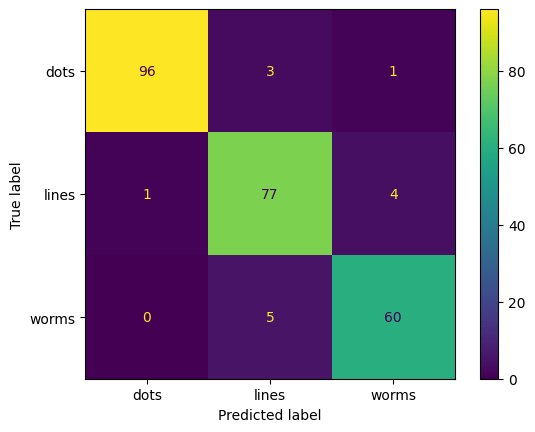

In [49]:
svc = SVC()

svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

plotConfusionMatrix(y_test, y_pred, svc)